In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v3_small
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import os

from PIL import Image

In [2]:
class DriveSemsegDataset(torch.utils.data.Dataset):

    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.data = os.listdir(root_dir)  # filenames
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # RGB image
        file = self.data[idx]
        img_rgb = Image.open(f'{self.root_dir}/{file}')
        img_rgb = self.transform(img_rgb)[:3, :, :]
        
        r, c = file.split('.')[0].split('_')
        file_pair = torch.tensor([int(r), int(c)])
        
        return img_rgb, file_pair

In [3]:
test_dataloader = torch.utils.data.DataLoader(DriveSemsegDataset('../FigImages/', 
                                                                 transforms.Compose([transforms.Resize((224, 224)),
                                                                                     transforms.ToTensor()])),
                                              batch_size=128,
                                              shuffle=True)

In [4]:
for img, pair in test_dataloader:
    print(img.shape)
    print(pair.shape)
    break

torch.Size([128, 3, 224, 224])
torch.Size([128, 2])


In [5]:
# '498_300.png' row_col

mobilenet_v3_small_model = mobilenet_v3_small(pretrained=True)

model = mobilenet_v3_small_model.cuda()
epoch, arch, state_dict = torch.load('model_19_0.58371.pth.tar').values()
model.load_state_dict(state_dict)
model = model.cuda()
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_r

In [12]:
outs = [0]*40000
indexes = [None]*40000

with torch.no_grad():
    i = 0
    for images, pair in tqdm(test_dataloader):
        images = images.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        predicted_cpu = predicted.cpu().tolist()
        pair_cpu = pair.cpu().tolist()
        for j in range(128):
            outs[128*i + j] = predicted_cpu[j]
            indexes[128*i + j] = pair_cpu[j]
            
        i += 1

  0%|          | 0/313 [00:00<?, ?it/s]

IndexError: list index out of range

In [17]:
import numpy as np

In [22]:
patch = np.zeros((200, 200), dtype=np.uint8)

In [23]:
for val, idx in zip(outs, indexes):
    patch[idx[0]-300, idx[1]-200] = val

In [29]:
%matplotlib notebook

<IPython.core.display.Javascript object>


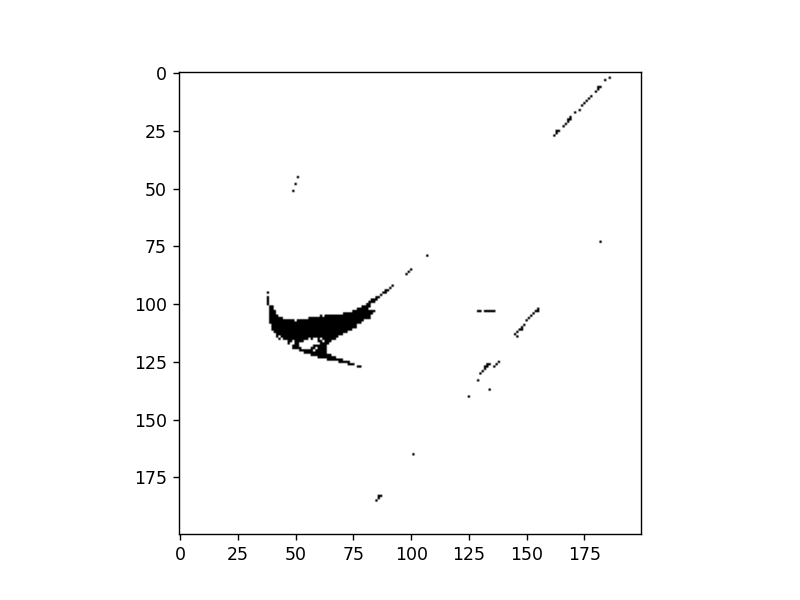

In [30]:
plt.imshow(np.bitwise_not(patch), cmap='gray')
plt.savefig('predction_fig.jpg')